# UNETを利用した, 水路のセマンティックセグメンテーション

## 概要
このコードでは, Oyoneによって収集された水路画像から作成された水路データセットを用いてセマンティックセグメンテーションを行う。

参考https://www.kaggle.com/code/ligtfeather/semantic-segmentation-is-easy-with-pytorch/notebook

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
import torchvision
import torch.nn.functional as F
from torch.autograd import Variable

from PIL import Image
import cv2
import albumentations as A  # Data Augmentation

import time
import os 
from tqdm import tqdm

import segmentation_models_pytorch as smp  # Segmentationのモデル

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


/Users/machidakentarou/GitHub/oyone_waterlane_detection/.venv/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 前処理

In [2]:
IMAGE_PATH = '../processed_data/voc_datasets/113_dataset_voc/JPEGImages/'
MASK_PATH = '../processed_data/voc_datasets/113_dataset_voc/SegmentationClassPNG/'

In [3]:
def create_df():
    name = []
    for dir_name, _, filenames in os.walk(IMAGE_PATH):
        for filename in filenames:
            name.append(filename.split('.')[0])

    return pd.DataFrame({'id': name}, index=np.arange(0, len(name)))

df = create_df()
print('Total Images: ', len(df))

Total Images:  137


In [4]:
TRAIN_RATE = 0.6
VAL_RATE = 0.2
TEST_RATE = 0.2

train_num = int(TRAIN_RATE*len(df))
val_num = int(VAL_RATE*len(df))
test_num = len(df) - train_num - val_num

df_train = df[0:train_num]
df_val = df[train_num:train_num+val_num]
df_test = df[train_num + val_num:]

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

print('Train size: ', len(df_train))
print('Val size: ', len(df_val))
print('Test size: ', len(df_test))

Train size:  82
Val size:  27
Test size:  28


Image Size (480, 640, 3)
Mask Size (480, 640)


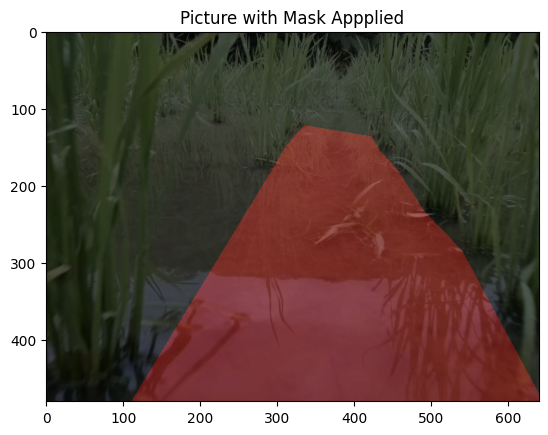

In [5]:
TEST_INDEX = 0
img = Image.open(IMAGE_PATH + df['id'][TEST_INDEX] + '.jpg')
mask = Image.open(MASK_PATH + df['id'][TEST_INDEX] + '.png')

print('Image Size', np.asarray(img).shape)
print('Mask Size', np.asarray(mask).shape)


plt.imshow(img)
plt.imshow(mask, alpha=0.6)
plt.title('Picture with Mask Appplied')
plt.show()

## Dataset

In [6]:
class WaterLaneDataset(Dataset):

    def __init__(self, img_path, mask_path, X, mean, std, transform=None, patch=False):
        self.img_path = img_path
        self.mask_path = mask_path
        self.X = X
        self.transform = transform
        self.patches = patch
        self.mean = mean
        self.std = std

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        img = cv2.imread(self.img_path + self.X[idx] + '.jpg')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        # load mask image as grey image
        mask = cv2.imread(self.mask_path + self.X[idx] + '.png', cv2.IMREAD_GRAYSCALE)

        if self.transform is not None:
            aug = self.transform(image=img, mask=mask)  # np.ndarray -> {'image': image, 'mask': mask}
            # convert ndarray to PIL.Image.Image to input torchvision.transforms
            img = Image.fromarray(aug['image'])
            mask = aug['mask']
            mask = mask == 38

        if self.transform is None:
            img = Image.fromarray(img)

        t = T.Compose([T.ToTensor(), T.Normalize(self.mean, self.std)])
        img = t(img)
        # torch loss function for segmentation task only accept int64(long)
        mask = torch.from_numpy(mask).long()  

        if self.patches:
            img, mask = self.tiles(img, mask)

        return img, mask

    def __checkimages__(self, idx):
        img = cv2.imread(self.img_path + self.X[idx] + '.jpg')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.mask_path + self.X[idx] + '.png', cv2.IMREAD_GRAYSCALE)

        if self.transform is not None:
            aug = self.transform(image=img, mask=mask)
            cvt_img = Image.fromarray(aug['image'])
            cvt_mask = aug['mask']

        if self.transform is None:
            cvt_img = Image.fromarray(img)
            cvt_mask = mask

        return img, cvt_img, mask, cvt_mask

    def tiles(self, img, mask):

        img_patches = img.unfold(1, 512, 512).unfold(2, 768, 768)
        img_patches  = img_patches.contiguous().view(3,-1, 512, 768) 
        img_patches = img_patches.permute(1,0,2,3)
        
        mask_patches = mask.unfold(0, 512, 512).unfold(1, 768, 768)
        mask_patches = mask_patches.contiguous().view(-1, 512, 768)
        
        return img_patches, mask_patches


## Data Augmentation
* データ拡張ツールalbumentationsを使用する。\
参考リンク: https://github.com/albumentations-team/albumentations \

* numpyarrayをパイプラインに通して前処理を行う。

* 水路データに必要そうなData Augmentation
    * ランダムな切り取り
    * 明るさの変化
    * データの拡大

In [8]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
WIDTH = 480
HEIGHT = 320

# 学習データのDataAugmentation
t_train = A.Compose([A.Resize(HEIGHT, WIDTH),
A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2),  #  画像の明るさの変化
A.GaussNoise()
])

# 検証データのDataAugmentation
t_val = A.Compose([A.Resize(HEIGHT, WIDTH)])

train_set = WaterLaneDataset(IMAGE_PATH, MASK_PATH, df_train['id'], mean, std, t_train, patch=False)
val_set = WaterLaneDataset(IMAGE_PATH, MASK_PATH,df_val['id'], mean, std, t_val, patch=False)

batch_size = 8

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True)

In [9]:
print(train_set.__getitem__(0)[1].shape)
print(train_set.__getitem__(0)[1].unique())

torch.Size([320, 480])
tensor([0, 1])


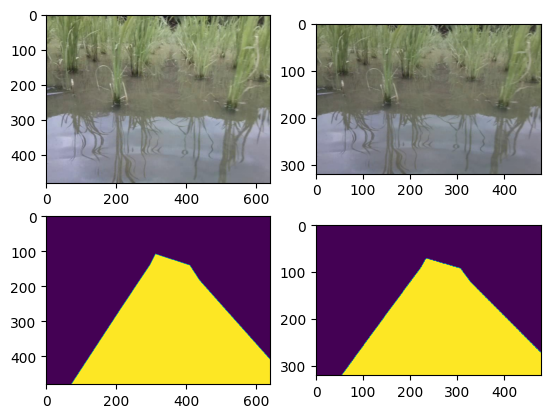

In [10]:
img, cvt_img, mask, cvt_mask = train_set.__checkimages__(2)
fig = plt.figure()
ax1 = fig.add_subplot(2, 2, 1)
plt.imshow(img)

ax2 = fig.add_subplot(2, 2, 2)
plt.imshow(cvt_img)

ax3 = fig.add_subplot(2, 2, 3)
plt.imshow(mask)

ax4 = fig.add_subplot(2, 2, 4)
plt.imshow(cvt_mask)

plt.show()

## Model

In [23]:
model = smp.Unet(
    'mobilenet_v2',
    encoder_weights='imagenet',
    classes=2, 
    activation=None,
    encoder_depth=5, 
    decoder_channels=[256, 128, 64, 32, 16]
    )
model

Unet(
  (encoder): MobileNetV2Encoder(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU6(inplace=True)
          )
          (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (2): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 96, kernel_size=(1

## Training

In [24]:
def pixel_accuracy(output, mask):
    with torch.no_grad():
        output = torch.argmax(F.softmax(output, dim=1), dim=1)  # 画素ごとの最大クラスを求める
        correct = torch.eq(output, mask).int()  # 予想ラベルがあってるところを1としたTensor
        accuracy = float(correct.sum()) / float(correct.numel())  # 全ピクセルの正答率
    return accuracy

In [25]:
def mIoU(pred_mask, mask, smooth=1e-10, n_classes=2):
    """
    IoUの計算関数
    pred_mask: モデルが出力した画素ごとのクラスごとの確率
    mask: 正解mask(int64のtensor)
    """
    with torch.no_grad():
        pred_mask = F.softmax(pred_mask, dim=1)  # (N, C, H, W)のCにsoftmax
        pred_mask = torch.argmax(pred_mask, dim=1)  # 画素ごとの最大クラスを取り出す
        pred_mask = pred_mask.contiguous().view(-1)  # maskを要素順にメモリに並べ(contiguous)1次元に(view)
        mask = mask.contiguous().view(-1)

        iou_per_class = []
        for clas in range(0, n_classes):  # loop per pixel class
            # clas ラベルの部分を1としたマスクを作成
            true_class = pred_mask == clas  
            true_label = mask == clas

            # 正解画像中に指定クラスのピクセルが1つもなければ, iou=0とする
            if true_label.long().sum().item() == 0:  # no exist label in this loop
                iou_per_class.append(np.nan)
            else:
                # 0以外の画素をTrue, 0をFalseとしてandとorをとる
                intersect = torch.logical_and(true_class, true_label).sum().float().item()
                union = torch.logical_or(true_class, true_label).sum().float().item()

                iou = (intersect + smooth) / (union + smooth)
                iou_per_class.append(iou)
        
        # nanを無視したIoUの平均値mIoUを返す
        return np.nanmean(iou_per_class)

In [28]:

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit(epochs, model, train_loader, val_loader, criterion, optimizer, scheduler, patch=False):
    torch.cuda.empty_cache()
    train_losses = []
    test_losses = []
    val_iou = []; val_acc = []
    train_iou = []; train_acc = []
    lrs = []
    min_loss = np.Inf
    decrease = 1; not_improve = 0

    model.to(device)
    fit_time = time.time()
    for e in range(epochs):
        since = time.time()
        running_loss = 0
        iou_score = 0
        accuracy = 0
        # training loop
        for i, data in enumerate(tqdm(train_loader)):
            # training phase
            image_tiles, mask_tiles = data
            if patch:
                bs, n_tiles, c, h, w = image_tiles.size()

                image_tiles = image_tiles.view(-1, c, h, w)
                mask_tiles = mask_tiles.view(-1, h, w)

            image = image_tiles.to(device); mask = mask_tiles.to(device)
            # forward
            output = model(image)
            # output: (N, C, H, W)Tensor, mask: (N, H, W)Tensor
            loss = criterion(output, mask)
            # evaluate metrics
            iou_score += mIoU(output, mask)
            accuracy += pixel_accuracy(output, mask)
            # backward
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            # step ths learning rate
            lrs.append(get_lr(optimizer))
            scheduler.step()

            running_loss += loss.item()

        else:  # for ~ else 'for が終了するとelseブロックが動き出す'
            print('----- evaluation -----')
            model.eval()
            test_loss = 0
            test_accuracy = 0
            val_iou_score = 0
            # validation loop
            with torch.no_grad():
                for i, data in enumerate(tqdm(val_loader)):
                    # reshape to 9 patches from single image, delete batch size
                    image_tiles, mask_tiles = data

                    if patch:
                        bs, n_tiles, c, h, w = image_tiles.size()

                        image_tiles = image_tiles.view(-1, c, h, w)
                        mask_tiles = mask_tiles.view(-1, h, w)

                    image = image_tiles.to(device); mask = mask_tiles.to(device)
                    output = model(image)
                    # evaluation metrics
                    val_iou_score += mIoU(output, mask)
                    test_accuracy += pixel_accuracy(output, mask)
                    # loss
                    loss = criterion(output, mask)
                    test_loss += loss.item()

            train_losses.append(running_loss/len(train_loader))
            test_losses.append(test_loss/len(val_loader))

            # 精度が向上した際の挙動、5回向上したらモデルの保存を行う
            if min_loss > (test_loss/len(val_loader)):
                print('Loss Decreasing.. {:.3f} >> {:.3f}'.format(min_loss, (test_loss/len(val_loader))))
                min_loss = (test_loss/len(val_loader))
                decrease += 1
                if decrease % 5 == 0:
                    print('saving model ...')
                    torch.save(model.state_dict(), '../trained_models/Unet-Mobilenet_v2_mIoU-{:.3f}.pt'.format(val_iou_score/len(val_loader)))

            # 精度が向上しなかったepochの挙動, 7連続向上しなかったら、学習中止
            if (test_loss/len(val_loader) > min_loss):
                not_improve += 1
                min_loss = (test_loss/len(val_loader))
                print(f'Loss Not Decrease for {not_improve} time')
                if not_improve == 7:
                    print('Loss not decrease for 7 times, Stop Training')
                    break

            # iou
            val_iou.append(val_iou_score/len(val_loader))
            train_iou.append(iou_score/len(train_loader))
            train_acc.append(accuracy/len(train_loader))
            val_acc.append(test_accuracy/ len(val_loader))
            print("Epoch:{}/{}..".format(e+1, epochs),
                  "Train Loss: {:.3f}..".format(running_loss/len(train_loader)),
                  "Val Loss: {:.3f}..".format(test_loss/len(val_loader)),
                  "Train mIoU:{:.3f}..".format(iou_score/len(train_loader)),
                  "Val mIoU: {:.3f}..".format(val_iou_score/len(val_loader)),
                  "Train Acc:{:.3f}..".format(accuracy/len(train_loader)),
                  "Val Acc:{:.3f}..".format(test_accuracy/len(val_loader)),
                  "Time: {:.2f}m".format((time.time()-since)/60))
        
    history = {'train_loss' : train_losses, 'val_loss': test_losses,
               'train_miou' :train_iou, 'val_miou':val_iou,
               'train_acc' :train_acc, 'val_acc':val_acc,
               'lrs': lrs}
    print('Total time: {:.2f} m' .format((time.time()- fit_time)/60))
    return history

In [29]:
max_lr = 1e-3
epoch = 15
weight_decay = 1e-4

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=max_lr, weight_decay=weight_decay)
sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epoch, steps_per_epoch=len(train_loader))
history = fit(epoch, model, train_loader, val_loader, criterion, optimizer, sched)

100%|██████████| 11/11 [00:58<00:00,  5.30s/it]


----- evaluation -----


100%|██████████| 4/4 [00:05<00:00,  1.41s/it]


Loss Decreasing.. inf >> 0.437
Epoch:1/15.. Train Loss: 0.571.. Val Loss: 0.437.. Train mIoU:0.525.. Val mIoU: 0.624.. Train Acc:0.700.. Val Acc:0.792.. Time: 1.07m


100%|██████████| 11/11 [00:59<00:00,  5.38s/it]


----- evaluation -----


100%|██████████| 4/4 [00:06<00:00,  1.53s/it]


Loss Not Decrease for 1 time
Epoch:2/15.. Train Loss: 0.373.. Val Loss: 0.453.. Train mIoU:0.694.. Val mIoU: 0.723.. Train Acc:0.829.. Val Acc:0.850.. Time: 1.09m


100%|██████████| 11/11 [00:52<00:00,  4.74s/it]


----- evaluation -----


100%|██████████| 4/4 [00:05<00:00,  1.47s/it]


Loss Not Decrease for 2 time
Epoch:3/15.. Train Loss: 0.530.. Val Loss: 0.607.. Train mIoU:0.657.. Val mIoU: 0.334.. Train Acc:0.809.. Val Acc:0.631.. Time: 0.97m


100%|██████████| 11/11 [00:50<00:00,  4.56s/it]


----- evaluation -----


100%|██████████| 4/4 [00:05<00:00,  1.44s/it]


Loss Not Decrease for 3 time
Epoch:4/15.. Train Loss: 0.888.. Val Loss: 0.695.. Train mIoU:0.367.. Val mIoU: 0.299.. Train Acc:0.618.. Val Acc:0.482.. Time: 0.93m


100%|██████████| 11/11 [00:51<00:00,  4.70s/it]


----- evaluation -----


100%|██████████| 4/4 [00:05<00:00,  1.34s/it]


Loss Decreasing.. 0.695 >> 0.613
Epoch:5/15.. Train Loss: 0.931.. Val Loss: 0.613.. Train mIoU:0.394.. Val mIoU: 0.458.. Train Acc:0.618.. Val Acc:0.631.. Time: 0.95m


100%|██████████| 11/11 [00:47<00:00,  4.36s/it]


----- evaluation -----


100%|██████████| 4/4 [00:05<00:00,  1.36s/it]


Loss Decreasing.. 0.613 >> 0.481
Epoch:6/15.. Train Loss: 0.619.. Val Loss: 0.481.. Train mIoU:0.487.. Val mIoU: 0.650.. Train Acc:0.670.. Val Acc:0.789.. Time: 0.89m


100%|██████████| 11/11 [00:47<00:00,  4.34s/it]


----- evaluation -----


100%|██████████| 4/4 [00:05<00:00,  1.36s/it]


Loss Decreasing.. 0.481 >> 0.432
saving model ...
Epoch:7/15.. Train Loss: 0.458.. Val Loss: 0.432.. Train mIoU:0.662.. Val mIoU: 0.671.. Train Acc:0.801.. Val Acc:0.812.. Time: 0.89m


100%|██████████| 11/11 [00:49<00:00,  4.53s/it]


----- evaluation -----


100%|██████████| 4/4 [00:05<00:00,  1.37s/it]


Loss Decreasing.. 0.432 >> 0.422
Epoch:8/15.. Train Loss: 0.441.. Val Loss: 0.422.. Train mIoU:0.668.. Val mIoU: 0.679.. Train Acc:0.807.. Val Acc:0.814.. Time: 0.92m


100%|██████████| 11/11 [00:47<00:00,  4.28s/it]


----- evaluation -----


100%|██████████| 4/4 [00:05<00:00,  1.32s/it]


Loss Decreasing.. 0.422 >> 0.369
Epoch:9/15.. Train Loss: 0.394.. Val Loss: 0.369.. Train mIoU:0.687.. Val mIoU: 0.692.. Train Acc:0.821.. Val Acc:0.825.. Time: 0.87m


100%|██████████| 11/11 [00:47<00:00,  4.31s/it]


----- evaluation -----


100%|██████████| 4/4 [00:05<00:00,  1.35s/it]


Loss Decreasing.. 0.369 >> 0.345
Epoch:10/15.. Train Loss: 0.362.. Val Loss: 0.345.. Train mIoU:0.700.. Val mIoU: 0.712.. Train Acc:0.829.. Val Acc:0.835.. Time: 0.88m


100%|██████████| 11/11 [00:46<00:00,  4.22s/it]


----- evaluation -----


100%|██████████| 4/4 [00:05<00:00,  1.36s/it]


Loss Not Decrease for 4 time
Epoch:11/15.. Train Loss: 0.347.. Val Loss: 0.355.. Train mIoU:0.713.. Val mIoU: 0.717.. Train Acc:0.836.. Val Acc:0.840.. Time: 0.87m


100%|██████████| 11/11 [00:47<00:00,  4.31s/it]


----- evaluation -----


100%|██████████| 4/4 [00:05<00:00,  1.38s/it]


Loss Not Decrease for 5 time
Epoch:12/15.. Train Loss: 0.327.. Val Loss: 0.361.. Train mIoU:0.735.. Val mIoU: 0.712.. Train Acc:0.851.. Val Acc:0.835.. Time: 0.88m


100%|██████████| 11/11 [00:47<00:00,  4.32s/it]


----- evaluation -----


100%|██████████| 4/4 [00:05<00:00,  1.37s/it]


Loss Not Decrease for 6 time
Epoch:13/15.. Train Loss: 0.323.. Val Loss: 0.362.. Train mIoU:0.736.. Val mIoU: 0.713.. Train Acc:0.851.. Val Acc:0.838.. Time: 0.88m


100%|██████████| 11/11 [00:47<00:00,  4.31s/it]


----- evaluation -----


100%|██████████| 4/4 [00:05<00:00,  1.37s/it]


Loss Decreasing.. 0.362 >> 0.355
Epoch:14/15.. Train Loss: 0.325.. Val Loss: 0.355.. Train mIoU:0.734.. Val mIoU: 0.714.. Train Acc:0.851.. Val Acc:0.837.. Time: 0.88m


100%|██████████| 11/11 [00:51<00:00,  4.66s/it]


----- evaluation -----


100%|██████████| 4/4 [00:05<00:00,  1.45s/it]

Loss Decreasing.. 0.355 >> 0.348
saving model ...
Epoch:15/15.. Train Loss: 0.325.. Val Loss: 0.348.. Train mIoU:0.734.. Val mIoU: 0.721.. Train Acc:0.849.. Val Acc:0.842.. Time: 0.95m
Total time: 13.92 m


In [30]:
torch.save(model.state_dict(), '../trained_models/Unet-Mobilenet_v2_mIoU-{:.3f}.pt'.format(0.721))

In [31]:
def plot_loss(history):
    plt.plot(history['val_loss'], label='val', marker='o')
    plt.plot( history['train_loss'], label='train', marker='o')
    plt.title('Loss per epoch'); plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()
    
def plot_score(history):
    plt.plot(history['train_miou'], label='train_mIoU', marker='*')
    plt.plot(history['val_miou'], label='val_mIoU',  marker='*')
    plt.title('Score per epoch'); plt.ylabel('mean IoU')
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()
    
def plot_acc(history):
    plt.plot(history['train_acc'], label='train_accuracy', marker='*')
    plt.plot(history['val_acc'], label='val_accuracy',  marker='*')
    plt.title('Accuracy per epoch'); plt.ylabel('Accuracy')
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()

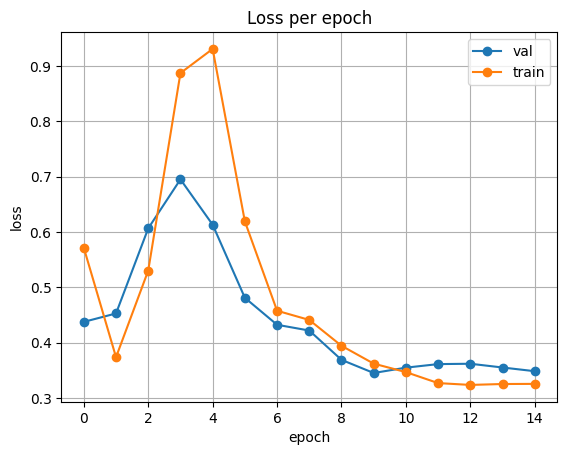

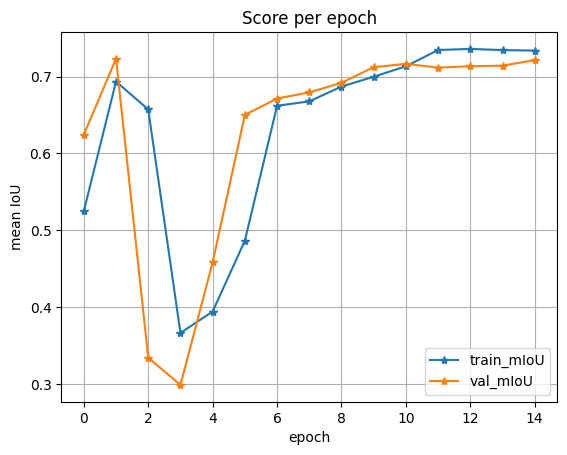

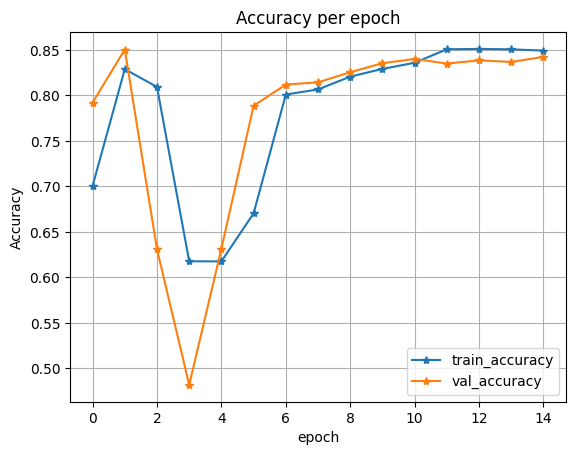

In [32]:
plot_loss(history)
plot_score(history)
plot_acc(history)

In [33]:
class WaterLaneTestDataset(Dataset):
    def __init__(self, img_path, mask_path, X, transform=None):
        self.img_path = img_path
        self.mask_path = mask_path
        self.X = X
        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        img = cv2.imread(self.img_path + self.X['id'][idx] + '.jpg')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.mask_path + self.X['id'][idx] + '.png', cv2.IMREAD_GRAYSCALE)

        if self.transform is not None:
            aug = self.transform(image=img, mask=mask)
            img = Image.fromarray(aug['image'])
            mask = aug['mask']
            mask = mask == 38
        
        if self.transform is None:
            img = Image.fromarray(img)
        
        mask = torch.from_numpy(mask).long()
        
        
        return img, mask

In [34]:
t_test = A.Resize(HEIGHT,WIDTH, interpolation=cv2.INTER_NEAREST)
test_set = WaterLaneTestDataset(IMAGE_PATH, MASK_PATH, df_test, transform=t_test)
test_set.__getitem__(0)

(<PIL.Image.Image image mode=RGB size=480x320>,
 tensor([[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0]]))

In [35]:
def predict_image_mask_miou(model, image, mask, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    model.eval()
    t = T.Compose([T.ToTensor(), T.Normalize(mean, std)])
    image = t(image)
    model.to(device); image=image.to(device)
    mask = mask.to(device)
    with torch.no_grad():
        
        image = image.unsqueeze(0)  # 3D tensor -> 4D tensor
        mask = mask.unsqueeze(0)
        
        output = model(image)
        score = mIoU(output, mask)
        masked = torch.argmax(output, dim=1)
        masked = masked.cpu().squeeze(0)
    return masked, score

In [36]:
def predict_image_mask_pixel(model, image, mask, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    model.eval()
    t = T.Compose([T.ToTensor(), T.Normalize(mean, std)])
    image = t(image)
    model.to(device); image=image.to(device)
    mask = mask.to(device)
    with torch.no_grad():
        
        image = image.unsqueeze(0)
        mask = mask.unsqueeze(0)
        
        output = model(image)
        acc = pixel_accuracy(output, mask)
        masked = torch.argmax(output, dim=1)
        masked = masked.cpu().squeeze(0)  # バッチ次元を削除
    return masked, acc


In [55]:
image, mask = test_set[16]
pred_mask, score = predict_image_mask_miou(model, image, mask)

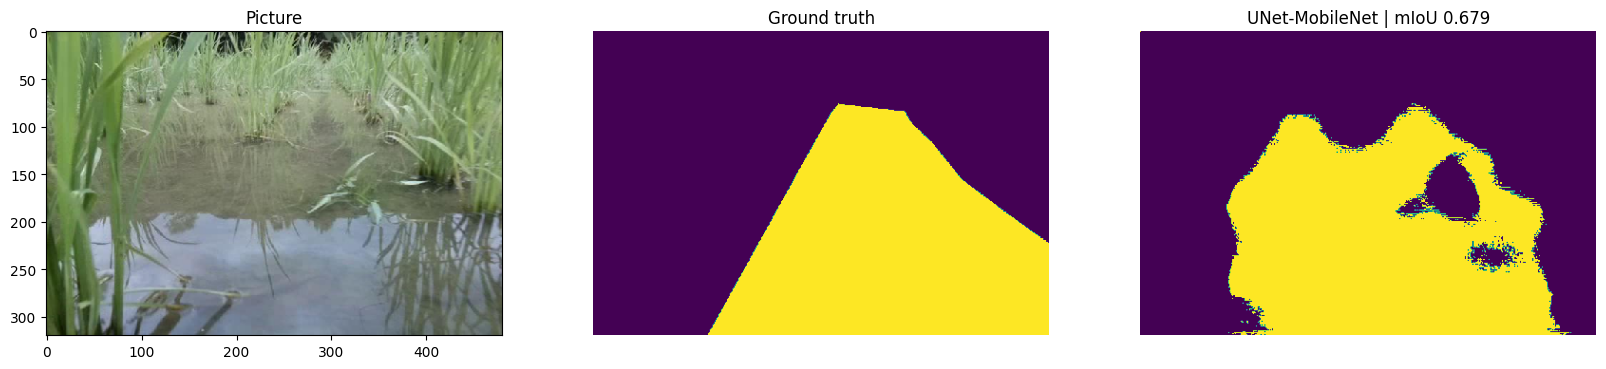

In [56]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,10))
ax1.imshow(image)
ax1.set_title('Picture')

ax2.imshow(mask)
ax2.set_title('Ground truth')
ax2.set_axis_off()

ax3.imshow(pred_mask)
ax3.set_title('UNet-MobileNet | mIoU {:.3f}'.format(score))
ax3.set_axis_off()

In [300]:
pred_mask

tensor([[1, 1, 1,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 0, 1],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [1, 0, 0,  ..., 0, 0, 1],
        [0, 0, 0,  ..., 0, 0, 1],
        [1, 1, 1,  ..., 0, 0, 1]])